# 图像分类预测

本教程介绍如何在MindCV中调用预训练模型，在测试图像上进行分类预测。

## 模型加载

### 查看全部可用的网络模型
通过调用`mindcv.models`中的`registry.list_models`函数，可以打印出全部网络模型的名字，一个网络在不同参数配置下的模型也会分别打印出来，例如densenet121 / densenet161 / densenet169 / densenet201。

In [1]:
from mindcv.models import registry
registry.list_models()

['densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'googlenet',
 ……,
 ……,
 'vgg16',
 'vgg19']

### 加载预训练模型
我们以densenet121模型为例，介绍两种使用`mindcv.models`中`create_model`函数进行模型checkpoint加载的方法。
1). 当接口中的`pretrained`参数设置为True时，可以自动下载网络权重。

In [2]:
from mindcv.models import create_model
model = create_model(model_name='densenet121', num_classes=1000, pretrained=True)
# 切换网络的执行逻辑为推理场景
model.set_train(False)

32293888B [01:19, 406656.85B/s]                               


2). 当接口中的`checkpoint_path`参数设置为文件路径时，可以从本地加载后缀为`.ckpt`的模型参数文件。

In [3]:
from mindcv.models import create_model
model = create_model(model_name='densenet121', num_classes=1000, checkpoint_path='./ckpt/densenet_121_imagenet2012.ckpt')
# 切换网络的执行逻辑为推理场景
model.set_train(False)

## 数据准备

### 构造数据集
这里，我们下载一张Wikipedia的图片作为测试图片，使用`mindcv.data`中的`create_dataset`函数，为单张图片构造自定义数据集。

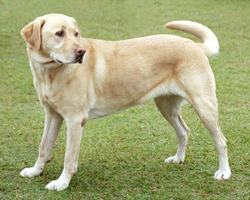

In [4]:
from mindcv.data import create_dataset
num_workers = 1

# 数据集目录路径
data_dir = "./data/test/"

dataset = create_dataset(root=data_dir, split='', num_parallel_workers=num_workers)

数据集的目录结构如下：

```Text
data/
└─ test
    ├─ dog
    │   ├─ dog.jpg
    │   └─ ……
    └─ ……
```

### 数据预处理
通过调用`create_transforms`函数，获得预训练模型使用的ImageNet数据集的数据处理策略(transform list)。

我们将得到的transform list传入`create_loader`函数，指定`batch_size=1`和其他参数，即可完成测试数据的准备，返回`Dataset` Object，作为模型的输入。

In [5]:
from mindcv.data import create_transforms, create_loader
transforms_list = create_transforms(dataset_name='ImageNet', is_training=False)
data_loader = create_loader(
        dataset=dataset,
        batch_size=1,
        is_training=False,
        num_classes=1000,
        transform=transforms_list,
        num_parallel_workers=num_workers
    )

## 模型推理
将自定义数据集的图片传入模型，获得推理的结果。这里使用`mindspore.ops`的`Squeeze`函数去除batch维度。

In [6]:
import mindspore.ops as P
import numpy as np
images, _ = next(data_loader.create_tuple_iterator())
output = P.Squeeze()(model(images))
pred = np.argmax(output.asnumpy())

In [7]:
with open("imagenet1000_clsidx_to_labels.txt") as f:
    idx2label = eval(f.read())
print('predict: {}'.format(idx2label[pred]))

predict: Labrador retriever
